In [9]:
#library import
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from IPython.display import display
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

data_dir='C:/Users/kdh2/BIGCON/data/total'
data_list = os.listdir(data_dir)


#항목별 저장
data_list_single_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인타자')]
data_single_hitter = [pd.read_csv(os.path.join(data_dir, data_list_single_hitter[x]), encoding='cp949') for x in range(len(data_list_single_hitter))]
data_list_single_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인투수')]
data_single_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_single_pitcher[x]), encoding='cp949') for x in range(len(data_list_single_pitcher))]
data_list_games = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('경기')]
data_games = [pd.read_csv(os.path.join(data_dir, data_list_games[x]), encoding='cp949') for x in range(len(data_list_games))]
data_list_player_enroll = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('등록선수')]
data_player_enroll = [pd.read_csv(os.path.join(data_dir, data_list_player_enroll[x]), encoding='cp949') for x in range(len(data_list_player_enroll))]
data_list_players = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('선수')]
data_players = [pd.read_csv(os.path.join(data_dir, data_list_players[x]), encoding='cp949') for x in range(len(data_list_players))]
data_list_teams = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀')]
data_teams = [pd.read_csv(os.path.join(data_dir, data_list_teams[x]), encoding='cp949') for x in range(len(data_list_teams))]
data_list_team_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀타자')]
data_team_hitter = [pd.read_csv(os.path.join(data_dir, data_list_team_hitter[x]), encoding='cp949') for x in range(len(data_list_team_hitter))]
data_list_team_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀투수')]
data_team_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_team_pitcher[x]), encoding='cp949') for x in range(len(data_list_team_pitcher))]



In [10]:
pitcher_2016=data_team_pitcher[0]
pitcher_2017=data_team_pitcher[1]
pitcher_2018=data_team_pitcher[2]
pitcher_2019=data_team_pitcher[3]
pitcher_2020=data_team_pitcher[4]
team_pitcher=pd.concat([pitcher_2016,pitcher_2017,pitcher_2018,pitcher_2019,pitcher_2020])

In [11]:
team_pitcher['ERA']=27*team_pitcher['ER']/team_pitcher['INN2']

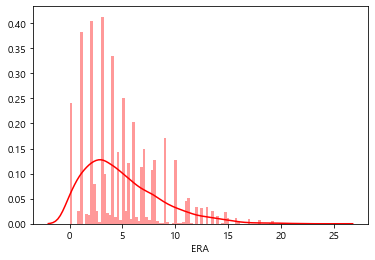

In [14]:
#모든 경기에 대한 방어율 분포
sns.distplot(team_pitcher['ERA'],bins=100,color='r')

In [15]:
team_pitcher['year']=team_pitcher['G_ID'].apply(lambda x: int(x[:4]))
team_pitcher['month']=team_pitcher['G_ID'].apply(lambda x: int(x[4:6]))

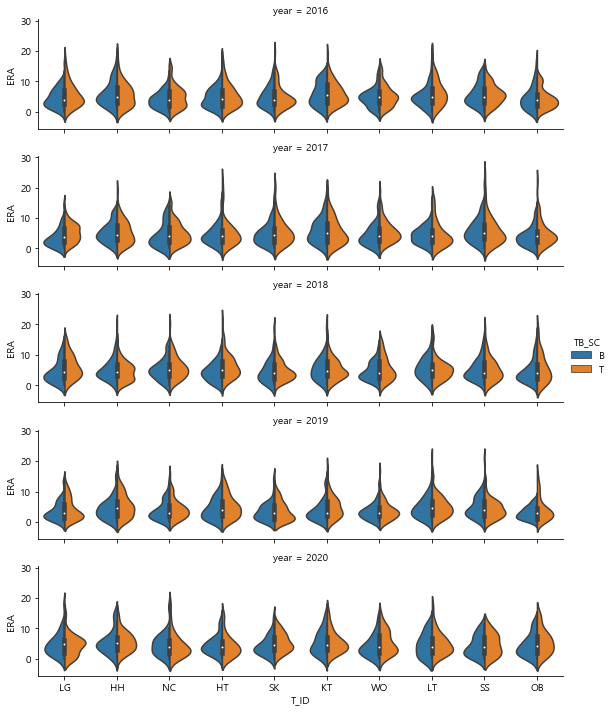

In [16]:
sns.catplot(x="T_ID", y="ERA", hue="TB_SC", row="year", data=team_pitcher,
            kind="violin", split=True, height=2, aspect=4)


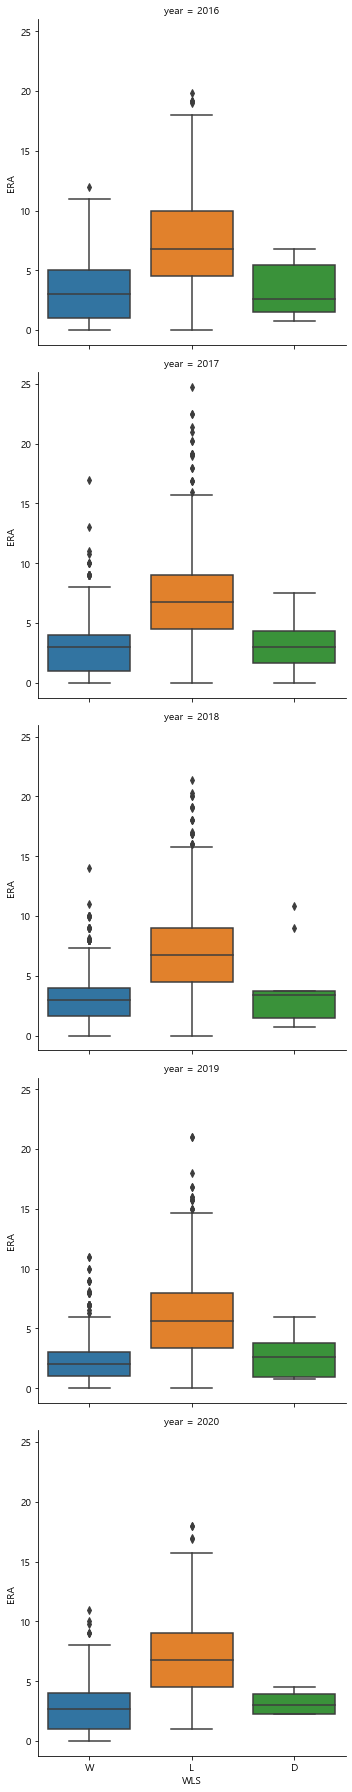

In [81]:
sns.factorplot(x='WLS',y='ERA',data=team_pitcher,kind='box',row='year')
#ERA와 승패는 높은 상관관계가 있음을 확인할 수 있다

In [22]:
team_pitcher.corr()['ERA']

GDAY_DS      -0.069842
HEADER_NO     0.001069
CG_CK        -0.116165
HOLD         -0.208513
INN2         -0.267426
BF            0.468324
PA            0.612847
AB            0.508384
HIT           0.761985
H2            0.469812
H3            0.200291
HR            0.543705
SB            0.109820
CS           -0.040585
SH            0.056509
SF            0.251936
BB            0.336309
IB            0.039797
HP            0.193850
KK           -0.156687
GD           -0.057068
WP            0.182315
BK            0.021368
ERR           0.020601
R             0.957248
ER            0.990714
P_WHIP_RT     0.562517
P2_WHIP_RT    0.505369
CB_WHIP_RT    0.489482
ERA           1.000000
year         -0.070169
month         0.031217
Name: ERA, dtype: float64

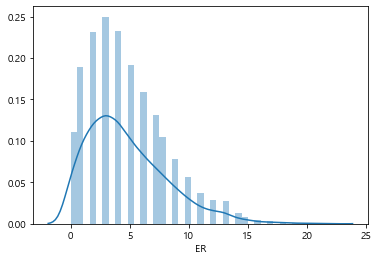

In [63]:
sns.distplot(team_pitcher['ER'])

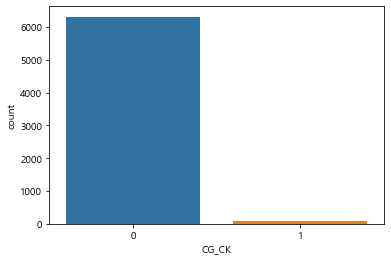

In [73]:
sns.countplot(team_pitcher['CG_CK'])
#어지간 해서는 투수 교체를 해주는데

완투한 선수 평균 ERA: 1.3155523255813952


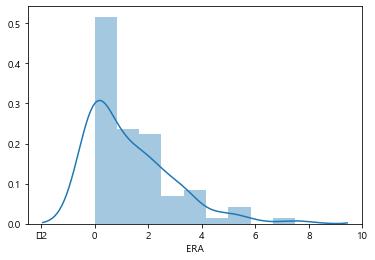

In [79]:
sns.distplot(team_pitcher[team_pitcher['CG_CK']==1]['ERA'])
print('완투한 선수 평균 ERA:',team_pitcher[team_pitcher['CG_CK']==1]['ERA'].mean())

평균 ERA: 4.94195994291249


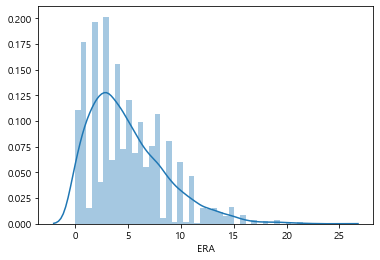

In [80]:
sns.distplot(team_pitcher['ERA'])
print('평균 ERA:',team_pitcher['ERA'].mean())

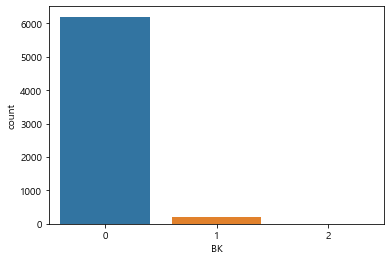

In [82]:
sns.countplot(team_pitcher['BK'])

In [84]:
team_pitcher[team_pitcher['BK']==2]
#보크가 2번이나 발생한 경기는 이상치로 처리해주는 게 좋을 것 같다

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,CG_CK,WLS,HOLD,INN2,...,BK,ERR,R,ER,P_WHIP_RT,P2_WHIP_RT,CB_WHIP_RT,ERA,year,month
293,20160508HHKT0,20160508,HH,KT,0,T,0,L,0,24,...,2,0,7,6,3.000000,2.470588,3.500000,6.75,2016,5
1112,20160823SKSS0,20160823,SS,SK,0,B,0,W,3,27,...,2,0,8,7,1.714286,1.736842,1.500000,7.00,2016,8
116,20170414SSLT0,20170414,LT,SS,0,B,0,W,0,27,...,2,0,6,5,1.090909,1.714286,2.000000,5.00,2017,4
150,20180412KTNC0,20180412,NC,KT,0,B,0,L,0,27,...,2,0,7,6,0.666667,2.000000,1.090909,6.00,2018,4


In [87]:
team_pitcher[team_pitcher['BK']==1]['ERA'].mean()
#보크가 일어난 경기의 평균 ERA는 그냥 전체 경기 평균인 4.9보다 0.6정도 높다.


5.345603032168815

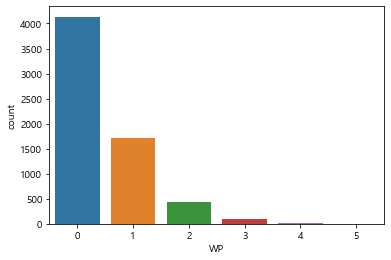

In [89]:
sns.countplot(team_pitcher['WP'])

In [93]:
team_pitcher[team_pitcher['WP']>1]['ERA']


2      4.000
11     7.200
32     3.000
40     6.000
53     5.625
       ...  
558    7.000
589    7.000
590    7.000
607    1.000
639    4.500
Name: ERA, Length: 561, dtype: float64

In [ ]:
team_pitcher[team_pitcher['WP']>1]['ERA'].mean()
#폭투가 일어난 경기의 평균 ERA는 전체 평균 ERA에 비해 매우 높다

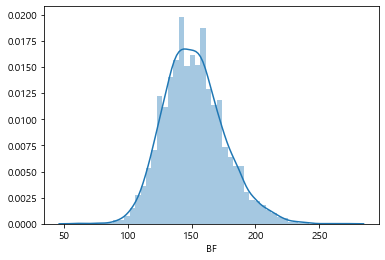

In [94]:
sns.distplot(team_pitcher['BF'])

In [96]:
team_pitcher['BF'].quantile(q=0.9)

183.0

In [99]:
team_pitcher[team_pitcher['BF']>183]['ERA']

0       3.000000
1       3.176471
11      7.200000
48      3.000000
68      3.000000
         ...    
606     9.000000
612     2.250000
613     2.250000
615    16.875000
618     9.000000
Name: ERA, Length: 632, dtype: float64

In [101]:
team_pitcher[team_pitcher['BF']>183]['ERA'].mean()
#투구수가 지나치게 많아질 경우 ERA가 높아지는 경향이 있는 것 같다

8.217421050118203

In [103]:
team_pitcher['BF'].quantile(q=0.1)

123.0

In [106]:
team_pitcher[team_pitcher['BF']<123]['ERA'].mean()
#반면 투구수가 적을경우 ERA가 낮아지는 경향이 있다.


2.475965638838773

In [110]:
team_pitcher.corr()['ERA'].sort_values()

INN2         -0.267426
HOLD         -0.208513
KK           -0.156687
CG_CK        -0.116165
year         -0.070169
GDAY_DS      -0.069842
GD           -0.057068
CS           -0.040585
HEADER_NO     0.001069
ERR           0.020601
BK            0.021368
month         0.031217
IB            0.039797
SH            0.056509
SB            0.109820
WP            0.182315
HP            0.193850
H3            0.200291
SF            0.251936
BB            0.336309
BF            0.468324
H2            0.469812
CB_WHIP_RT    0.489482
P2_WHIP_RT    0.505369
AB            0.508384
HR            0.543705
P_WHIP_RT     0.562517
PA            0.612847
HIT           0.761985
R             0.957248
ER            0.990714
ERA           1.000000
Name: ERA, dtype: float64